Copyright **`(c)`** 2025 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [21]:
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import math
from matplotlib import pyplot as plt

In [37]:
class KnapsackOptimizer:
    def __init__(self, params):
        """Initialize with parameters from dictionary."""
        self.constraints = params['constraints']
        self.weights = params['weights']
        self.values = params['values']
        self.num_knapsacks = params['num_knapsacks']
        self.num_items = params['num_items']

        self.iterations = params.get('iterations', 10000)
        self.initial_temp = params.get('initial_temperature', 10 * math.log10(self.num_items * self.weights.shape[1]))
        self.final_temp = params.get('final_temperature', self.initial_temp * 0.01)
        self.early_stop = params.get('early_stop', self.iterations // 5)

        self.best_values = []
        self.best_solution = None
        self.best_value = 0
    
    def __str__(self):
        """Return a human-readable string representation of the optimizer."""
        s = f"KnapsackOptimizer:\n"
        s += f"  Problem size: {self.num_items} items, {self.num_knapsacks} knapsacks, {self.weights.shape[1]} dimensions\n"
        s += f"  Temperature: {self.initial_temp:.2f} → {self.final_temp:.2f}\n"
        s += f"  Iterations: {self.iterations} (early stop after {self.early_stop} non-improving iterations)\n"
        
        if hasattr(self, 'best_value') and self.best_value > 0:
            s += f"  Optimization status: Complete\n"
            s += f"  Best value: {self.best_value}\n"
            if hasattr(self, 'best_values') and self.best_values:
                s += f"  Progress: {self.best_values[0]} → {self.best_values[-1]}\n"
                improvement = (self.best_values[-1] / self.best_values[0] - 1) * 100
                s += f"  Improvement: {improvement:.1f}%\n"
        else:
            s += f"  Optimization status: Not started\n"
        
        return s

    def __repr__(self):
        """Return a string representation of the optimizer."""
        return f"KnapsackOptimizer(items={self.num_items}, knapsacks={self.num_knapsacks}, dims={self.weights.shape[1]})"

    """ =============================================HELPER METHODS ============================================= """
    def space_left(self, knapsack):
        """Compute remaining capacity for a single knapsack."""
        used = self.weights[knapsack].sum(axis=0)
        return self.constraints - used


    def is_valid(self, knapsacks):
        """Check if all knapsacks are within constraints."""
        for k in range(self.num_knapsacks):
            selected_items = np.where(knapsacks[k])[0]
            if len(selected_items) > 0:
                knapsack_weights = self.weights[selected_items].sum(axis=0)
                if np.any(knapsack_weights > self.constraints):
                    return False
        return True

    def value(self, knapsacks):
        """Calculate total value of items in all knapsacks."""
        total_value = 0
        for k in range(self.num_knapsacks):
            selected_items = np.where(knapsacks[k])[0]
            total_value += self.values[selected_items].sum()
        return total_value

    def random_valid_solution(self):
        """Generate a random valid solution."""
        knapsacks = np.zeros((self.num_knapsacks, self.num_items), dtype=bool)

        while True:
            for item in range(self.num_items):
                k = np.random.randint(self.num_knapsacks)
                if np.all(self.space_left(knapsacks[k]) >= self.weights[item]):
                    knapsacks[k][item] = True
            if self.is_valid(knapsacks):
                break
        return knapsacks
    
    def plot_optimization(self):
        """Plot the progress of the optimization."""
        plt.plot(range(len(self.best_values)), self.best_values, label='Best Value')
        plt.xlabel('Iterations')
        plt.ylabel('Value')
        plt.title('Knapsack Optimization Progress')
        plt.legend()

    """ ====================================== OPTIMIZATION METHODS ========================================== """
    def random_edit(self, knapsacks):
        k = np.random.randint(self.num_knapsacks)
        knapsacks = knapsacks.copy()
        op = np.random.choice(["add", "remove", "transfer"])

        if op == "add":
            available = np.where(~np.any(knapsacks, axis=0))[0]
            if available.size:
                item = np.random.choice(available)
                if np.all(self.space_left(knapsacks[k]) >= self.weights[item]):
                    knapsacks[k][item] = True

        elif op == "remove":
            items = np.where(knapsacks[k])[0]
            if items.size:
                knapsacks[k][np.random.choice(items)] = False

        else:  # transfer
            k2 = np.random.randint(self.num_knapsacks)
            if k2 != k:
                items = np.where(knapsacks[k])[0]
                if items.size:
                    item = np.random.choice(items)
                    if np.all(self.space_left(knapsacks[k2]) >= self.weights[item]):
                        knapsacks[k][item] = False
                        knapsacks[k2][item] = True

        return knapsacks

    def greedy_edit(self, knapsacks):
        """Combine value-based editing with transfer optimization."""
        knapsacks = knapsacks.copy()
        
        # First try to add unassigned items
        assigned_mask = np.any(knapsacks, axis=0)
        unassigned_items = np.where(~assigned_mask)[0]
        
        if len(unassigned_items) > 0:
            # Vectorized value density calculation
            weight_norms = np.linalg.norm(self.weights[unassigned_items], axis=1)
            value_densities = self.values[unassigned_items] / (weight_norms + 1e-9)
            
            # Sort by density
            sorted_indices = np.argsort(-value_densities)
            sorted_items = unassigned_items[sorted_indices]
            
            # Try to add high-value items to knapsacks where they fit best
            for item in sorted_items:
                best_k = -1
                best_fit = -1
                
                for k in range(self.num_knapsacks):
                    space_left = self.space_left(knapsacks[k])
                    
                    if np.all(space_left >= self.weights[item]):
                        # Calculate how well this item fits
                        fit_score = 0
                        for d in range(len(self.constraints)):
                            if space_left[d] > 0:
                                utilization = self.weights[item][d] / space_left[d]
                                fit_score += utilization
                        
                        if fit_score > best_fit:
                            best_k = k
                            best_fit = fit_score
                
                if best_k != -1:
                    knapsacks[best_k][item] = True
        
        # Then try to optimize transfers
        improved = True
        max_passes = 3  # Reduced from 10 to make it faster
        passes = 0
        
        while improved and passes < max_passes:
            improved = False
            passes += 1
            
            for item in range(self.num_items):
                current_ks = np.where(knapsacks[:, item])[0]
                if len(current_ks) == 0:
                    continue
                
                current_k = current_ks[0]
                
                # Check if moving to another knapsack would be better
                for k in range(self.num_knapsacks):
                    if k == current_k:
                        continue
                    
                    # Check if item fits in target knapsack
                    if np.all(self.space_left(knapsacks[k]) >= self.weights[item]):
                        # Check if this move would allow adding more valuable items
                        current_space_after_remove = self.space_left(knapsacks[current_k]) + self.weights[item]
                        
                        # Find best item that could be added to current knapsack after removal
                        best_additional_value = 0
                        for other_item in range(self.num_items):
                            if not np.any(knapsacks[:, other_item]) and np.all(current_space_after_remove >= self.weights[other_item]):
                                if self.values[other_item] > best_additional_value:
                                    best_additional_value = self.values[other_item]
                        
                        # If we can get more value by moving, do it
                        if best_additional_value > self.values[item]:
                            knapsacks[current_k][item] = False
                            knapsacks[k][item] = True
                            improved = True
                            break
        
        return knapsacks

    def edit_solution(self, knapsacks, temperature):
        """Apply a probabilistic edit to the solution."""
        knapsacks = knapsacks.copy()
        p_random = min(1, temperature)  # high temp = more random
        
        if np.random.rand() < p_random:
            return self.random_edit(knapsacks)
        else:
            return self.greedy_edit(knapsacks)

    def tweak(self, knapsacks, temperature):
        """Tweak solution based on temperature."""
        knapsacks = knapsacks.copy()
        max_attempts = 20
        attempt = 0
        
        while attempt < max_attempts:
            new_solution = self.edit_solution(knapsacks, temperature)
            
            if self.is_valid(new_solution):
                return new_solution
            
            attempt += 1
        return knapsacks.copy()

    def acceptance(self, delta, temp):
        """Calculate the acceptance probability based on delta and temperature."""
        return 1.0 if delta > 0 else math.exp(delta / temp)

    def temperature_at(self, step):
        """Calculate temperature at the given step using exponential cooling schedule."""
        return self.initial_temp * (self.final_temp / self.initial_temp) ** (step / self.iterations)

    def optimize(self):
        """Perform simulated annealing to optimize knapsack solution."""
        self._space_cache = {}
        sol = self.random_valid_solution()
        val = self.value(sol)
        best_sol, best_val = sol.copy(), val
        self.best_values, no_improve = [], 0
        
        pbar = tqdm(range(self.iterations), desc="Optimizing")
        for i in pbar:
            T = self.temperature_at(i)
            new_sol = self.tweak(sol, T)
            new_val = self.value(new_sol)
            delta = new_val - val
            
            if np.random.rand() < self.acceptance(delta, T):
                sol, val = new_sol, new_val
                if val > best_val:
                    best_sol, best_val, no_improve = sol.copy(), val, 0
                else:
                    no_improve += 1
            else:
                no_improve += 1
                
            # Early stopping check
            if no_improve >= self.early_stop:
                pbar.set_postfix({'value': best_val, 'temp': T, 'status': 'early stopped'}, refresh=True)
                tqdm.write("Early stopping.")
                break
                
            # Restart from best solution if stuck for a while but not enough to stop
            if no_improve > 1000 and no_improve < self.early_stop:
                sol = deepcopy(best_sol)
                val = best_val
                no_improve = 0
            
            self.best_values.append(best_val)
            pbar.set_postfix({'value': best_val, 'temp': T}, refresh=True)
        
        self.best_solution, self.best_value = best_sol, best_val

## TEST PROBLEMS

In [ ]:
RANDOM_SEED = 42

In [ ]:
# Problem 1:
rng = np.random.default_rng(seed=RANDOM_SEED)

params = {
    'num_items': 20,
    'num_dimensions': 2,
    'num_knapsacks': 3,
    'values': rng.integers(0, 100, size=20),
    'weights': rng.integers(0, 100, size=(20, 2)),
    'constraints': rng.integers(0, 100 * 20 // 3, size=2),
    'iterations': 10000,
    'initial_temperature': 100.0,
    'early_stop': 4000
}

ko1 = KnapsackOptimizer(params)
ko1.optimize()
print(ko1)

Optimizing: 100%|██████████| 10000/10000 [00:46<00:00, 213.59it/s, value=1065, temp=0.01] 

KnapsackOptimizer:
  Problem size: 20 items, 3 knapsacks, 2 dimensions
  Temperature: 100.00 → 0.01
  Iterations: 10000 (early stop after 4000 non-improving iterations)
  Optimization status: Complete
  Best value: 1065
  Progress: 949 → 1065
  Improvement: 12.2%



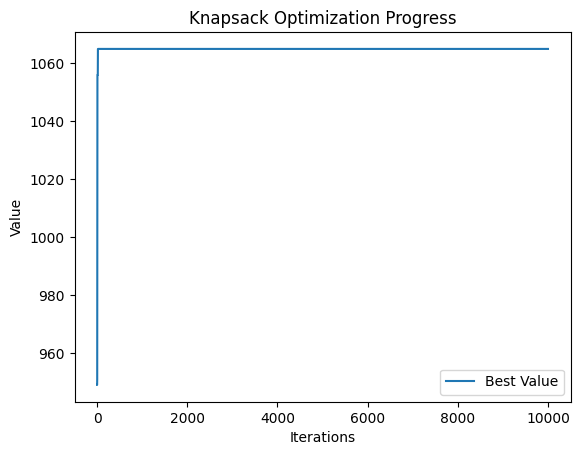

In [24]:
ko1.plot_optimization()

In [ ]:
# Problem 2:
rng = np.random.default_rng(seed=RANDOM_SEED)

params = {
    'num_items': 100,
    'num_dimensions': 10,
    'num_knapsacks': 10,
    'values': rng.integers(0, 1000, size=100),
    'weights': rng.integers(0, 1000, size=(100, 10)),
    'constraints': rng.integers(1000 * 2, 1000 * 100 // 10, size=10),
    'iterations': 10000,
    'initial_temperature': 100.0
}

ko2 = KnapsackOptimizer(params)
ko2.optimize()
print(ko2)

Optimizing: 100%|██████████| 10000/10000 [00:21<00:00, 471.30it/s, value=35605, temp=1]  

KnapsackOptimizer:
  Problem size: 100 items, 10 knapsacks, 10 dimensions
  Temperature: 100.00 → 1.00
  Iterations: 10000 (early stop after 2000 non-improving iterations)
  Optimization status: Complete
  Best value: 35605
  Progress: 26163 → 35605
  Improvement: 36.1%



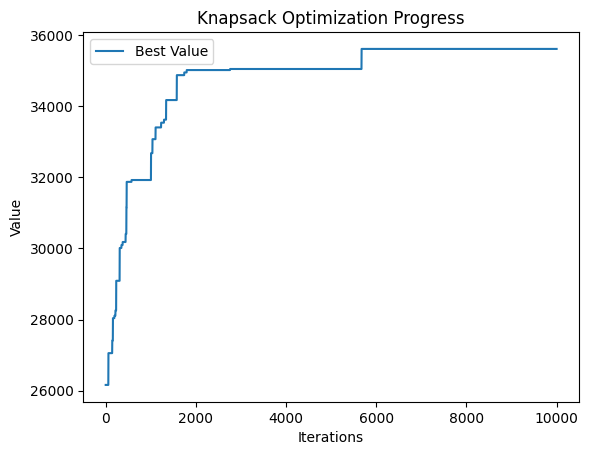

In [29]:
ko2.plot_optimization()

In [ ]:
# Problem 3:
rng = np.random.default_rng(seed=RANDOM_SEED)

params = {
    'num_items': 5000,
    'num_dimensions': 100,
    'num_knapsacks': 100,
    'values': rng.integers(0, 1000, size=5000),
    'weights': rng.integers(0, 1000, size=(5000, 100)),
    'constraints': rng.integers(1000 * 10, 1000 * 2 * 5000 // 100, size=100),
    'iterations': 50000,
    'initial_temperature': 400.0
}

ko3 = KnapsackOptimizer(params)
ko3.optimize()
print(ko3)

Optimizing: 100%|██████████| 50000/50000 [07:49<00:00, 106.52it/s, value=1437606, temp=4]   

KnapsackOptimizer:
  Problem size: 5000 items, 100 knapsacks, 100 dimensions
  Temperature: 400.00 → 4.00
  Iterations: 50000 (early stop after 10000 non-improving iterations)
  Optimization status: Complete
  Best value: 1437606
  Progress: 1154030 → 1437606
  Improvement: 24.6%



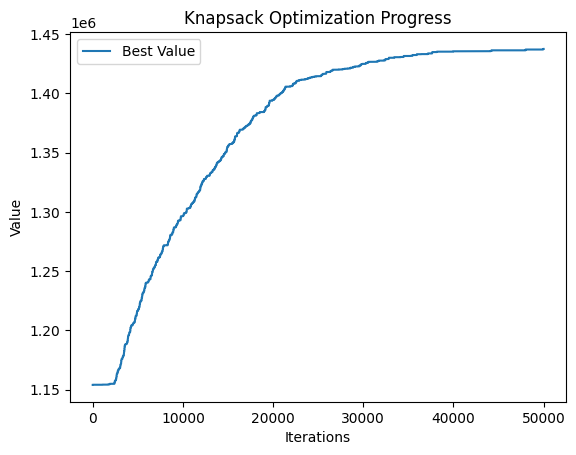

In [36]:
ko3.plot_optimization()